# 1. Libraries


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import joblib

from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.ensemble import RandomForestRegressor
from statsmodels.tsa.arima.model import ARIMA
from keras.layers import LSTM, Dense
from keras.models import Sequential
from xgboost import XGBRegressor

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, RobustScaler, OneHotEncoder


# 2. Loading dataset and EDA

In [123]:
data = pd.read_csv('../data/clean_hcmc_waq.csv', delimiter=",")
data.head()

,date_time,temperature_2m,relative_humidity_2m,dew_point_2m,apparent_temperature,precipitation,cloud_cover,vapour_pressure_deficit,wind_speed_10m,wind_direction_10m,pm10,pm2_5,carbon_monoxide,nitrogen_dioxide,sulphur_dioxide,ozone,us_aqi,weather_status
0,2022-10-01 07:00:00,25.511000,94.49476,24.561,31.543438,1.3,44.700000,0.179606,2.902413,209.74480,61.2,42.1,1123.0,50.80,11.50,4.0,73.652490,Light Rain
1,2022-10-01 08:00:00,26.411001,88.26100,24.311,31.320229,0.6,55.500000,0.403905,9.504272,232.69597,36.9,24.9,906.0,43.05,11.25,14.0,76.471634,Moderate Drizzle
2,2022-10-01 09:00:00,26.911001,88.03870,24.761,32.211530,0.7,46.200005,0.423807,8.788720,214.99210,28.0,18.5,598.0,31.95,10.90,27.0,77.597520,Moderate Drizzle
3,2022-10-01 10:00:00,28.011000,85.29904,25.311,33.920822,0.6,100.000000,0.555415,7.072878,194.74360,24.2,15.9,281.0,19.70,10.50,48.0,78.182625,Moderate Drizzle
4,2022-10-01 11:00:00,29.011000,78.12226,24.811,34.491055,0.4,100.000000,0.875935,7.754637,201.80147,26.0,17.1,213.0,14.25,10.50,67.0,78.430855,Light Drizzle


In [124]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17544 entries, 0 to 17543
Data columns (total 18 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   date_time                17544 non-null  object 
 1   temperature_2m           17544 non-null  float64
 2   relative_humidity_2m     17544 non-null  float64
 3   dew_point_2m             17544 non-null  float64
 4   apparent_temperature     17544 non-null  float64
 5   precipitation            17544 non-null  float64
 6   cloud_cover              17544 non-null  float64
 7   vapour_pressure_deficit  17544 non-null  float64
 8   wind_speed_10m           17544 non-null  float64
 9   wind_direction_10m       17544 non-null  float64
 10  pm10                     17544 non-null  float64
 11  pm2_5                    17544 non-null  float64
 12  carbon_monoxide          17544 non-null  float64
 13  nitrogen_dioxide         17544 non-null  float64
 14  sulphur_dioxide       

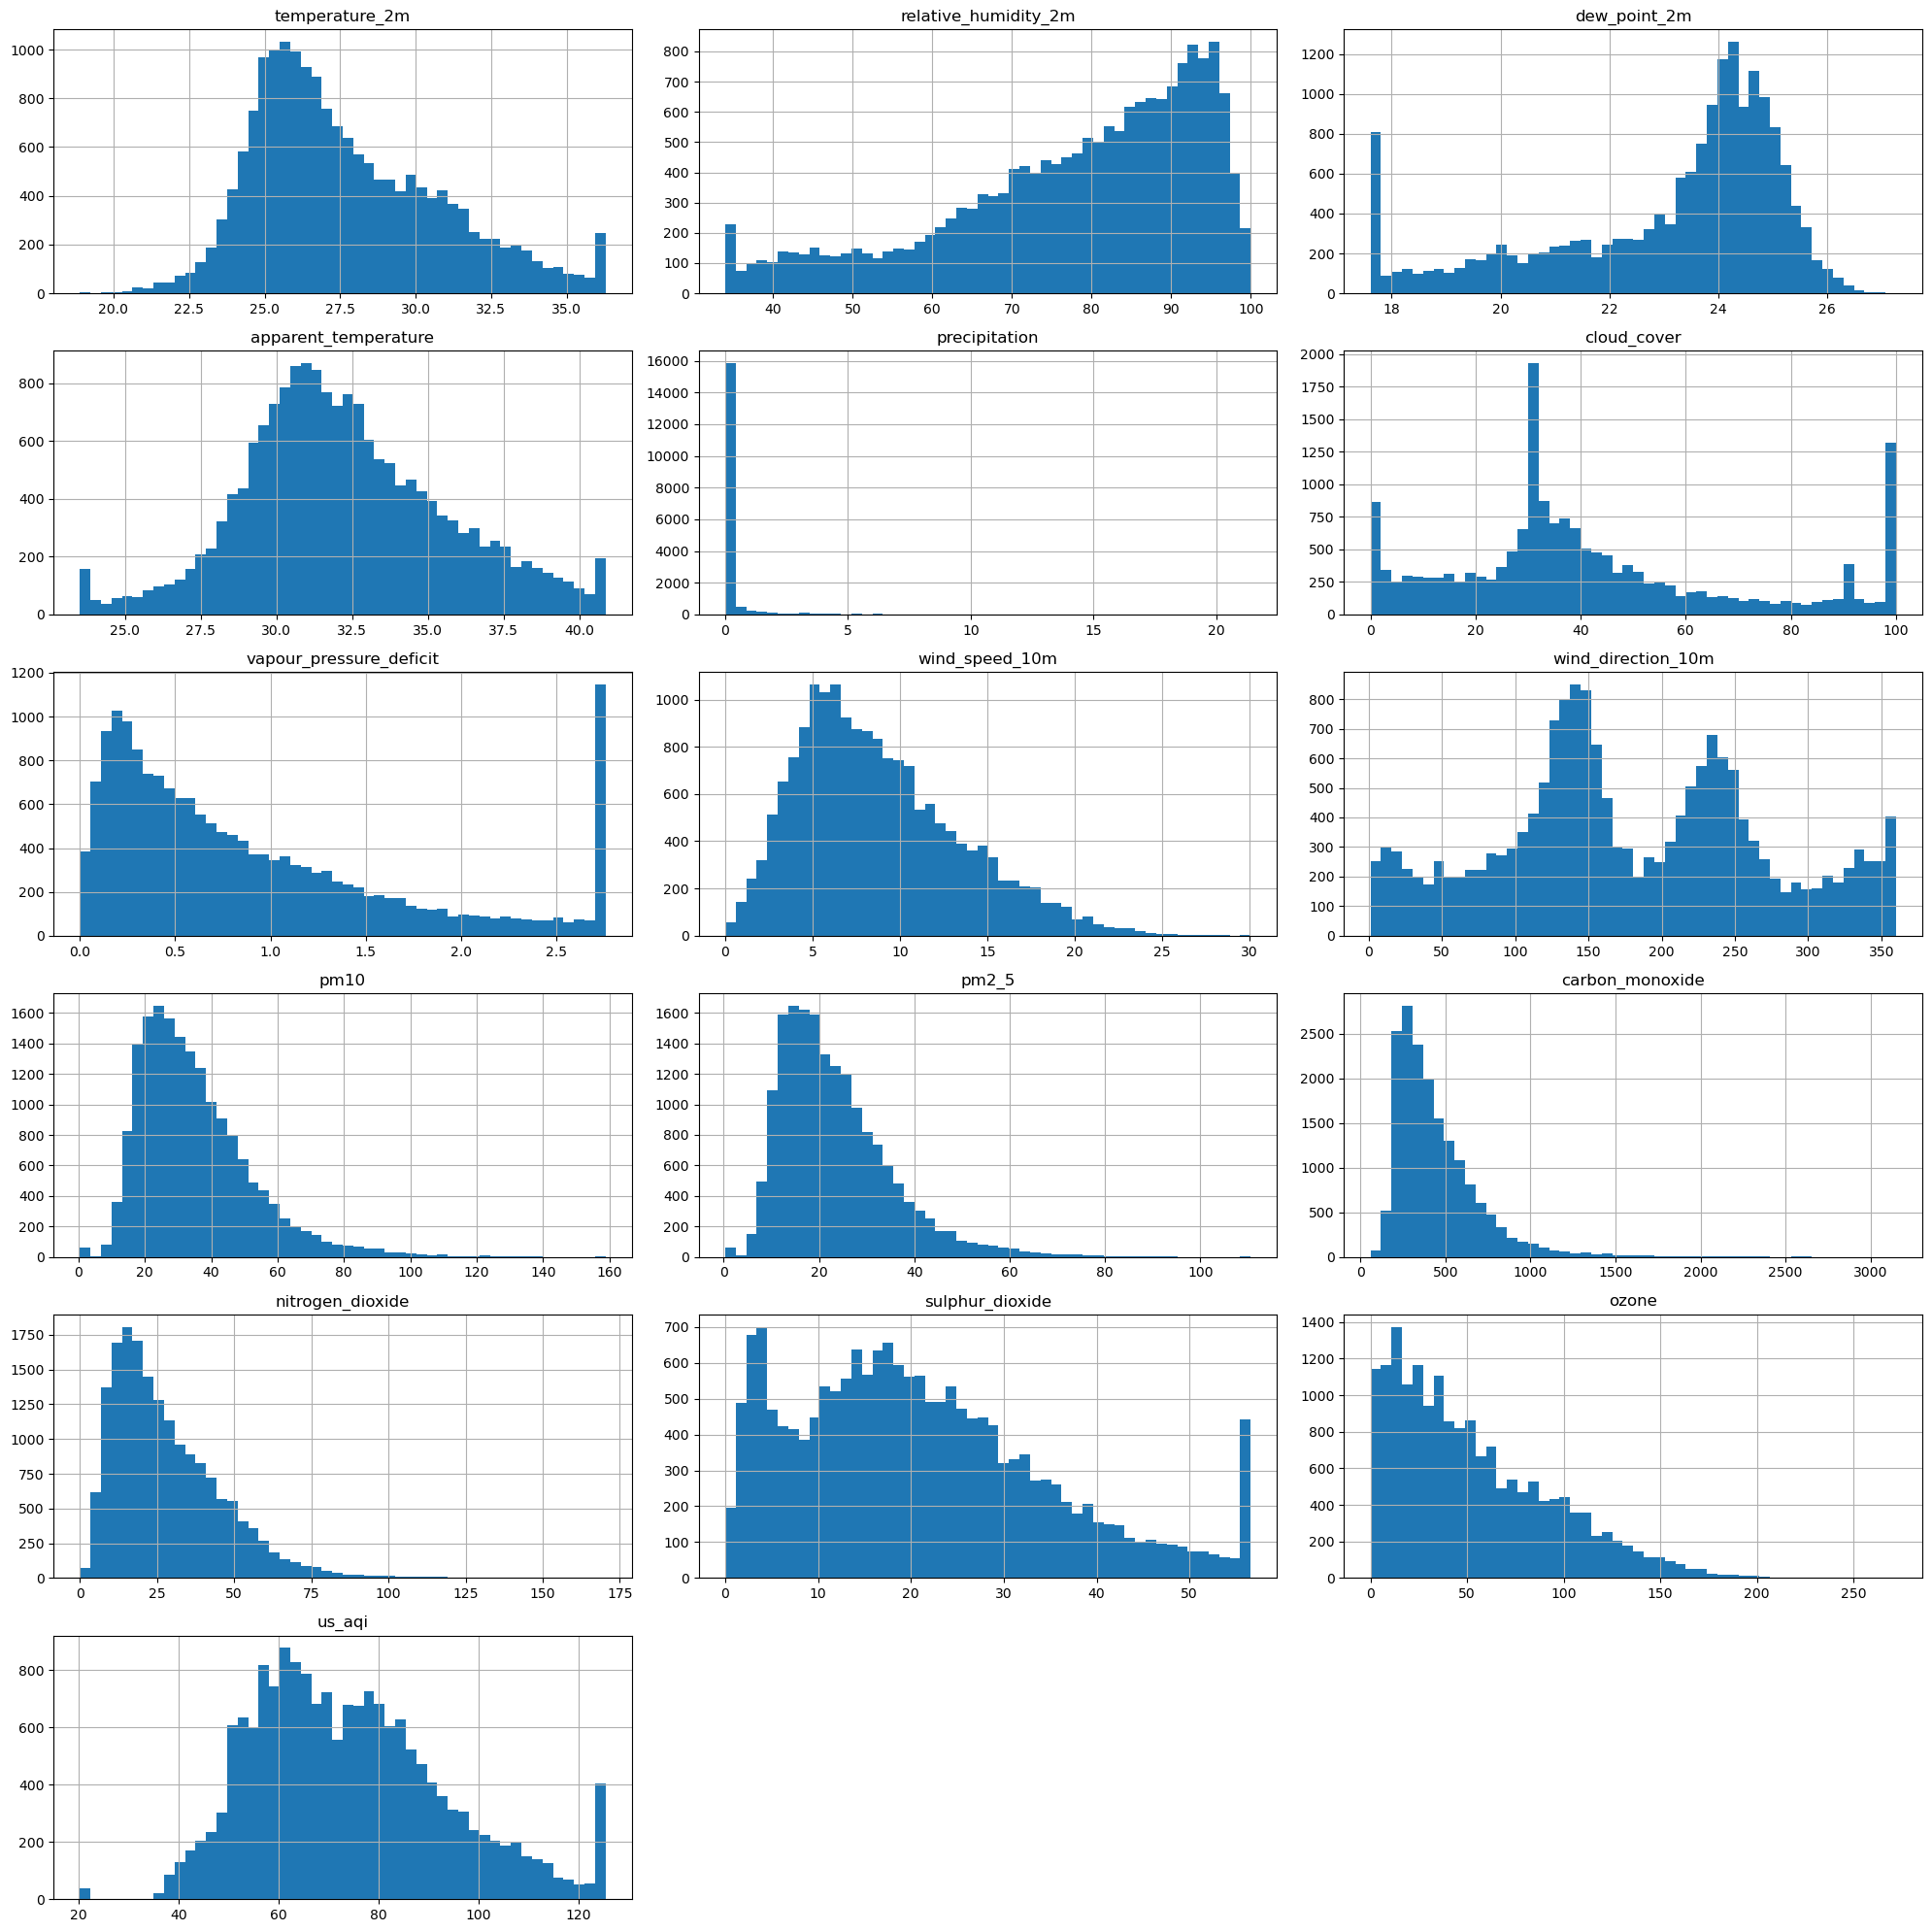

In [125]:
data.hist(figsize=(20, 20), bins=50, layout=(6, 3))
plt.tight_layout()
plt.show()

# 3. Preprocessing dataset

## 0. Preprocessing date_time 

In [ ]:
target = 'us_aqi'

data['date_time'] = pd.to_datetime(data['date_time'])
data.set_index('date_time', inplace=True)

## 1. Scale numeric features

In [127]:
numeric_features = [col for col in data.columns if data[col].dtype != 'object' and col != target]

std_scaler = StandardScaler()
robust_scaler = RobustScaler()

robust_scaled_data = data.copy()
std_scaled_data = data.copy()

robust_scaled_data[numeric_features] = robust_scaler.fit_transform(robust_scaled_data[numeric_features])
std_scaled_data[numeric_features] = std_scaler.fit_transform(std_scaled_data[numeric_features])

scaled_data = std_scaled_data.copy()
scaled_data.head()


,temperature_2m,relative_humidity_2m,dew_point_2m,apparent_temperature,precipitation,cloud_cover,vapour_pressure_deficit,wind_speed_10m,wind_direction_10m,pm10,pm2_5,carbon_monoxide,nitrogen_dioxide,sulphur_dioxide,ozone,us_aqi,weather_status
date_time,,,,,,,,,,,,,,,,,
2022-10-01 07:00:00,-0.707377,1.035719,0.687277,-0.204351,0.959470,0.108360,-0.940007,-1.265070,0.348822,1.541658,1.581827,2.629139,1.260873,-0.693860,-1.193231,73.652490,Light Rain
2022-10-01 08:00:00,-0.418294,0.653450,0.574224,-0.270232,0.313040,0.500538,-0.650646,0.148402,0.602837,0.111548,0.122975,1.783882,0.828115,-0.712200,-0.949673,76.471634,Moderate Drizzle
2022-10-01 09:00:00,-0.257692,0.639818,0.777719,-0.007163,0.405387,0.162830,-0.624972,-0.004799,0.406897,-0.412237,-0.419853,0.584162,0.208294,-0.737876,-0.633048,77.597520,Moderate Drizzle
2022-10-01 10:00:00,0.095631,0.471815,1.026436,0.497337,0.313040,2.116453,-0.455189,-0.372165,0.182794,-0.635875,-0.640377,-0.650615,-0.475742,-0.767220,-0.121576,78.182625,Moderate Drizzle
2022-10-01 11:00:00,0.416834,0.031717,0.800330,0.665642,0.128346,2.116453,-0.041698,-0.226199,0.260908,-0.529941,-0.538597,-0.915488,-0.780068,-0.767220,0.341184,78.430855,Light Drizzle


## 2. Encoding 'weather_status'

In [128]:
# Initialize OneHotEncoder
encoder = OneHotEncoder(sparse_output=False, drop='first')

# One-hot encode the 'weather_status' column
encoded_feature = encoder.fit_transform(scaled_data[['weather_status']])

# Get column names for encoded features
encoded_col_names = encoder.get_feature_names_out(['weather_status'])

# Create a DataFrame for the encoded features with proper column names
encoded_feature_df = pd.DataFrame(encoded_feature, columns=encoded_col_names, index=scaled_data.index)

# Concatenate the encoded features with the rest of the data
encoded_data = pd.concat([scaled_data.drop(columns=["weather_status"]), encoded_feature_df], axis=1)

encoded_data.head()

,temperature_2m,relative_humidity_2m,dew_point_2m,apparent_temperature,precipitation,cloud_cover,vapour_pressure_deficit,wind_speed_10m,wind_direction_10m,pm10,...,us_aqi,weather_status_Dense Drizzle,weather_status_Heavy Rain,weather_status_Light Drizzle,weather_status_Light Rain,weather_status_Mainly Clear,weather_status_Moderate Drizzle,weather_status_Moderate Rain,weather_status_Overcast,weather_status_Partly Cloudy
date_time,,,,,,,,,,,,,,,,,,,,,
2022-10-01 07:00:00,-0.707377,1.035719,0.687277,-0.204351,0.959470,0.108360,-0.940007,-1.265070,0.348822,1.541658,...,73.652490,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2022-10-01 08:00:00,-0.418294,0.653450,0.574224,-0.270232,0.313040,0.500538,-0.650646,0.148402,0.602837,0.111548,...,76.471634,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2022-10-01 09:00:00,-0.257692,0.639818,0.777719,-0.007163,0.405387,0.162830,-0.624972,-0.004799,0.406897,-0.412237,...,77.597520,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2022-10-01 10:00:00,0.095631,0.471815,1.026436,0.497337,0.313040,2.116453,-0.455189,-0.372165,0.182794,-0.635875,...,78.182625,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2022-10-01 11:00:00,0.416834,0.031717,0.800330,0.665642,0.128346,2.116453,-0.041698,-0.226199,0.260908,-0.529941,...,78.430855,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [129]:
preproc_data = encoded_data
other_features = [col for col in preproc_data.columns if col != target]

# 4. Training models

## 0. Prepare saving path

In [130]:
import os

model_save_path = '../model2/'
if not os.path.exists(model_save_path):
    os.makedirs(model_save_path)

## 1. ARIMA

In [131]:
arima_data = preproc_data[target]
arima_data = arima_data.asfreq('h')

train_size = int(len(arima_data) * 0.8)
train, test = arima_data[:train_size], arima_data[train_size:]

arima_model = ARIMA(train, order=(5, 1, 0))
arima_result = arima_model.fit()

arima_forecast = arima_result.forecast(steps=len(test))
arima_mse = mean_squared_error(test, arima_forecast)

joblib.dump(arima_result, model_save_path + "arima_model.pkl")
print(f"ARIMA MSE: {arima_mse}")

ARIMA MSE: 541.790172837407


## 2. SARIMA

In [ ]:
sarima_data = preproc_data[target].asfreq('h')

train_size = int(len(sarima_data) * 0.8)
train, test = sarima_data[:train_size], arima_data[train_size:]

sarima_model = SARIMAX(train, order=(5, 1, 0), seasonal_order=(1, 1, 1, 24)) 
sarima_result = sarima_model.fit()

sarima_forecast = sarima_result.forecast(steps=len(test))
sarima_mse = mean_squared_error(test, sarima_forecast)

joblib.dump(sarima_result, model_save_path + "sarima_model.pkl")
print(f"SARIMA MSE: {sarima_mse}")

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.13734D+00    |proj g|=  4.65661D-01


 This problem is unconstrained.



At iterate    5    f=  9.79529D-01    |proj g|=  7.43844D-02

At iterate   10    f=  9.27689D-01    |proj g|=  1.48390D-02

At iterate   15    f=  9.22592D-01    |proj g|=  3.91346D-02

At iterate   20    f=  9.22118D-01    |proj g|=  1.06145D-03

At iterate   25    f=  9.22090D-01    |proj g|=  4.03058D-04

At iterate   30    f=  9.22087D-01    |proj g|=  1.35262D-03

At iterate   35    f=  9.22086D-01    |proj g|=  9.82630D-05

At iterate   40    f=  9.22086D-01    |proj g|=  1.25923D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     42     54      1     0     0   3.976D-05   9.221D-01
  F =  0.922085914180

## 3. Random Forest Regressor

In [133]:
data = preproc_data.copy()
for lag in range(1, 13):
    data[f'us_aqi_lag_{lag}'] = data[target].shift(lag)
data.dropna(inplace=True)

X = data[[f'us_aqi_lag_{i}' for i in range(1, 13)] + other_features]
y = data[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

rf_forecast = rf_model.predict(X_test)
rf_mse = mean_squared_error(y_test, rf_forecast)

joblib.dump(rf_model, model_save_path + "random_forest_model.pkl")
print(f"Random Forest MSE: {rf_mse}")

Random Forest MSE: 0.1832033333537709


## 4. XGBoost Regressor

In [134]:
X_train_xgb, X_test_xgb, y_train_xgb, y_test_xgb = train_test_split(X, y, test_size=0.2, random_state=42)

xgb = XGBRegressor()
xgb.fit(X_train_xgb, y_train_xgb)
xgb_predictions = xgb.predict(X_test_xgb)
xgb_mse = mean_squared_error(y_test, xgb_predictions)

joblib.dump(xgb, model_save_path + "xgboost_model.pkl")
print(f"XGBoost MSE: {xgb_mse}")

XGBoost MSE: 648.5508195881272


## 5. LSTM 

In [ ]:
data = preproc_data.copy().values 

def create_sequences(data, target_col, seq_length):
    X, y = [], []
    for i in range(seq_length, len(data)):
        X.append(data[i-seq_length:i, :])
        y.append(data[i, target_col])
    return np.array(X), np.array(y)

seq_length = 12
X, y = create_sequences(data, target_col=0, seq_length=seq_length)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

lstm_model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    LSTM(50),
    Dense(1)
])
lstm_model.compile(optimizer='adam', loss='mse')
lstm_model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test))

lstm_forecast = lstm_model.predict(X_test)

lstm_forecast_reshaped = np.zeros((lstm_forecast.shape[0], len(numeric_features)))
lstm_forecast_reshaped[:, 0] = lstm_forecast[:, 0]

lstm_mse = mean_squared_error(y_test, robust_scaler.inverse_transform(lstm_forecast_reshaped)[:, 0])
print(f"LSTM MSE: {lstm_mse}")

lstm_model.save(model_save_path + "lstm_model.keras")

Epoch 1/20


/home/van/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


439/439 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.4227 - val_loss: 0.0645
Epoch 2/20
439/439 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0448 - val_loss: 0.0547
Epoch 3/20
439/439 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0395 - val_loss: 0.0425
Epoch 4/20
439/439 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0372 - val_loss: 0.0391
Epoch 5/20
439/439 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0345 - val_loss: 0.0389
Epoch 6/20
439/439 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0326 - val_loss: 0.0403
Epoch 7/20
439/439 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0340 - val_loss: 0.0386
Epoch 8/20
439/439 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0340 - val_loss: 0.0401
Epoch 9/20
439/439 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0306 - val_loss: 0.0378
Epoch 10/20
439/439 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0317 - val_loss: 0.0392
Epoch 11/20
439/439 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0317 - val_loss: 0.0356
Epoch 12/20
439/439 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.

## 6. Testing results

In [136]:
results = {
    "ARIMA": arima_mse,
    "SARIMA": sarima_mse,
    "Random Forest": rf_mse,
    "XGBoost": xgb_mse,
    "LSTM": lstm_mse
}

results_df = pd.DataFrame.from_dict(results, orient='index', columns=['MSE'])
results_df.to_csv("model_results.csv")
print(results_df)

                      MSE
ARIMA          541.790173
SARIMA         610.636716
Random Forest    0.183203
XGBoost        648.550820
LSTM           745.236969
